## Building Research Agent with LangGraph,GPT-4o,RAG,Pinecone,ArXiv and GoogleSerpAPI

### Extracting data from ArXiv and Pandas

In [4]:
pip install -q google-search-results

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
import requests
import pandas as pd
import json
import xml.etree.ElementTree as ET

ARXIV_NAMESPACE='{http://www.w3.org/2005/Atom}'

def extract_from_arxiv(search_query='cat:cs.AI', max_results=100, json_file_path='files/arxiv_dataset.json'):
    """
    Fetches papers from the ArXiv API based on a search query, saves them as JSON, 
    and returns a pandas DataFrame.

    Args:
        search_query (str): The search query for ArXiv (default is 'cat:cs.AI').
        max_results (int): The maximum number of results to retrieve (default is 100).
        json_file_path (str): File path where JSON data will be saved.

    Returns:
        pd.DataFrame: DataFrame containing the extracted paper information.
    """
    
    # Construct the URL for the API request.
    url = f'http://export.arxiv.org/api/query?search_query={search_query}&max_results={max_results}'
    
    # Send a GET request to the ArXiv API.
    response = requests.get(url)
    
    # Parse the XML response.
    root = ET.fromstring(response.content)
    print(f'Total entries found: {len(root.findall(f"{ARXIV_NAMESPACE}entry"))}')
    
    papers = []
    
    # Loop through each "entry" in the XML, representing a single paper.
    for entry in root.findall(f'{ARXIV_NAMESPACE}entry'):
        title = entry.find(f'{ARXIV_NAMESPACE}title').text.strip()
        summary = entry.find(f'{ARXIV_NAMESPACE}summary').text.strip()

        # Get the authors of the paper.
        author_elements = entry.findall(f'{ARXIV_NAMESPACE}author')
        authors = [author.find(f'{ARXIV_NAMESPACE}name').text for author in author_elements]

        # Get the paper's URL.
        paper_url = entry.find(f'{ARXIV_NAMESPACE}id').text
        arxiv_id = paper_url.split('/')[-1]

        # Check for the PDF link.
        pdf_link = next((link.attrib['href'] for link in entry.findall(f'{ARXIV_NAMESPACE}link') 
                         if link.attrib.get('title') == 'pdf'), None)

        papers.append({
            'title': title,
            'summary': summary,
            'authors': authors,
            'arxiv_id': arxiv_id,
            'url': paper_url,
            'pdf_link': pdf_link
        })
    
    # Convert list into a pandas DataFrame.
    df = pd.DataFrame(papers)
    
    # Save the DataFrame to a JSON file.
    with open(json_file_path, 'w', encoding='utf-8') as f:
        json.dump(papers, f, ensure_ascii=False, indent=4)
        print(f'Data saved to {json_file_path} ...')
    
    return df


In [37]:
df=extract_from_arxiv(max_results=20)

Total entries found: 20
Data saved to files/arxiv_dataset.json ...


In [38]:
import json
import pandas as pd
file_name='files/arxiv_dataset.json'
with open(file_name,'r') as file:
    data=json.load(file)

df=pd.DataFrame(data)

# print(data)
#df.sample(n=5)

### Downloading Research papers

In [39]:
import pandas as pd
import requests
import os

def download_pdfs(df, download_folder='files'):
    """
    Downloads PDFs from URLs listed in the DataFrame and saves them to a specified folder. 
    The file names are stored in a new column 'pdf_file_name' in the DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing a 'pdf_link' column with URLs to download.
        download_folder (str): Path to the folder where PDFs will be saved (default is 'files').
    
    Returns:
        pd.DataFrame: The original DataFrame with an additional 'pdf_file_name' column containing 
                      the paths of the downloaded PDF files or None if the download failed.
    """
    
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)
    
    pdf_file_names = []
    
    # Loop through each row to download PDFs
    for index, row in df.iterrows():
        pdf_link = row['pdf_link']
        
        try:
            response = requests.get(pdf_link)
            response.raise_for_status()
    
            file_name = os.path.join(download_folder, pdf_link.split('/')[-1]) + '.pdf'
            pdf_file_names.append(file_name)
    
            # Save the downloaded PDF
            with open(file_name, 'wb') as f:
                f.write(response.content)
            
            print(f'PDF downloaded successfully and saved as {file_name}')
        
        except requests.exceptions.RequestException as e:
            print(f'Failed to download the PDF: {e}')
            pdf_file_names.append(None)
    
    df['pdf_file_name'] = pdf_file_names

    return df

In [40]:
df=download_pdfs(df)

PDF downloaded successfully and saved as files\9308101v1.pdf
PDF downloaded successfully and saved as files\9308102v1.pdf
PDF downloaded successfully and saved as files\9309101v1.pdf
PDF downloaded successfully and saved as files\9311101v1.pdf
PDF downloaded successfully and saved as files\9311102v1.pdf
PDF downloaded successfully and saved as files\9312101v1.pdf
PDF downloaded successfully and saved as files\9401101v1.pdf
PDF downloaded successfully and saved as files\9402101v1.pdf
PDF downloaded successfully and saved as files\9402102v1.pdf
PDF downloaded successfully and saved as files\9402103v1.pdf
PDF downloaded successfully and saved as files\9403101v1.pdf
PDF downloaded successfully and saved as files\9406101v1.pdf
PDF downloaded successfully and saved as files\9406102v1.pdf
PDF downloaded successfully and saved as files\9408101v1.pdf
PDF downloaded successfully and saved as files\9408102v1.pdf
PDF downloaded successfully and saved as files\9408103v1.pdf
PDF downloaded successfu

In [41]:
df

,title,summary,authors,arxiv_id,url,pdf_link,pdf_file_name
0,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,http://arxiv.org/pdf/cs/9308101v1,files\9308101v1.pdf
1,A Market-Oriented Programming Environment and ...,Market price systems constitute a well-underst...,[M. P. Wellman],9308102v1,http://arxiv.org/abs/cs/9308102v1,http://arxiv.org/pdf/cs/9308102v1,files\9308102v1.pdf
2,An Empirical Analysis of Search in GSAT,We describe an extensive study of search in GS...,"[I. P. Gent, T. Walsh]",9309101v1,http://arxiv.org/abs/cs/9309101v1,http://arxiv.org/pdf/cs/9309101v1,files\9309101v1.pdf
3,The Difficulties of Learning Logic Programs wi...,As real logic programmers normally use cut (!)...,"[F. Bergadano, D. Gunetti, U. Trinchero]",9311101v1,http://arxiv.org/abs/cs/9311101v1,http://arxiv.org/pdf/cs/9311101v1,files\9311101v1.pdf
4,Software Agents: Completing Patterns and Const...,To support the goal of allowing users to recor...,"[J. C. Schlimmer, L. A. Hermens]",9311102v1,http://arxiv.org/abs/cs/9311102v1,http://arxiv.org/pdf/cs/9311102v1,files\9311102v1.pdf
5,Decidable Reasoning in Terminological Knowledg...,Terminological knowledge representation system...,"[M. Buchheit, F. M. Donini, A. Schaerf]",9312101v1,http://arxiv.org/abs/cs/9312101v1,http://arxiv.org/pdf/cs/9312101v1,files\9312101v1.pdf
6,Teleo-Reactive Programs for Agent Control,A formalism is presented for computing and org...,[N. Nilsson],9401101v1,http://arxiv.org/abs/cs/9401101v1,http://arxiv.org/pdf/cs/9401101v1,files\9401101v1.pdf
7,Learning the Past Tense of English Verbs: The ...,Learning the past tense of English verbs - a s...,[C. X. Ling],9402101v1,http://arxiv.org/abs/cs/9402101v1,http://arxiv.org/pdf/cs/9402101v1,files\9402101v1.pdf
8,Substructure Discovery Using Minimum Descripti...,The ability to identify interesting and repeti...,"[D. J. Cook, L. B. Holder]",9402102v1,http://arxiv.org/abs/cs/9402102v1,http://arxiv.org/pdf/cs/9402102v1,files\9402102v1.pdf
9,Bias-Driven Revision of Logical Domain Theories,The theory revision problem is the problem of ...,"[M. Koppel, R. Feldman, A. M. Segre]",9402103v1,http://arxiv.org/abs/cs/9402103v1,http://arxiv.org/pdf/cs/9402103v1,files\9402103v1.pdf


### Loading and Splitting PDF Files into chunks, Expanding the DataFrame

In [42]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

def load_and_chunk_pdf(pdf_file_name, chunk_size=512):
    """
    Loads a PDF file and splits its content into chunks of a specified size.

    Args:
        file (str): Path to the PDF file to be loaded.
        chunk_size (int): The maximum size of each chunk in characters (default is 512).

    Returns:
        List[Document]: A list of document chunks.
    """

    print(f'Loading and splitting into chunks: {pdf_file_name}')

    # Load the content of the PDF
    loader = PyPDFLoader(pdf_file_name)
    data = loader.load()

    # Split the content into chunks with slight overlap to preserve context
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=64)
    chunks = text_splitter.split_documents(data)

    return chunks

def expand_df(df):
    """
    Expands each row in the DataFrame by splitting PDF documents into chunks.

    Args:
        df (pd.DataFrame): DataFrame containing 'pdf_file_name', 'arxiv_id', 'title', 'summary', 
                           'authors', and 'url' columns.

    Returns:
        pd.DataFrame: A new DataFrame where each row represents a chunk of the original document, 
                      with additional metadata such as chunk identifiers and relationships to 
                      adjacent chunks.
    """

    expanded_rows = []  # List to store expanded rows with chunk information

    # Loop through each row in the DataFrame
    for idx, row in df.iterrows():
        try:
            chunks = load_and_chunk_pdf(row['pdf_file_name'])
        except Exception as e:
            print(f"Error processing file {row['pdf_file_name']}: {e}")
            continue

        # Loop over the chunks and construct a new DataFrame row for each
        for i, chunk in enumerate(chunks):
            prechunk_id = i-1 if i > 0 else ''  # Preceding chunk ID
            postchunk_id = i+1 if i < len(chunks) - 1 else ''  # Following chunk ID

            expanded_rows.append({
                'id': f"{row['arxiv_id']}#{i}",  # Unique chunk identifier
                'title': row['title'],
                'summary': row['summary'],
                'authors': row['authors'],
                'arxiv_id': row['arxiv_id'],
                'url': row['url'],
                'chunk': chunk.page_content,  # Text content of the chunk
                'prechunk_id': '' if i == 0 else f"{row['arxiv_id']}#{prechunk_id}",  # Previous chunk ID
                'postchunk_id': '' if i == len(chunks) - 1 else f"{row['arxiv_id']}#{postchunk_id}"  # Next chunk ID
            })

    # Return a new expanded DataFrame
    return pd.DataFrame(expanded_rows)

In [43]:
expand_df=expand_df(df)

Loading and splitting into chunks: files\9308101v1.pdf
Loading and splitting into chunks: files\9308102v1.pdf
Loading and splitting into chunks: files\9309101v1.pdf
Loading and splitting into chunks: files\9311101v1.pdf
Loading and splitting into chunks: files\9311102v1.pdf
Loading and splitting into chunks: files\9312101v1.pdf
Loading and splitting into chunks: files\9401101v1.pdf
Loading and splitting into chunks: files\9402101v1.pdf
Loading and splitting into chunks: files\9402102v1.pdf
Loading and splitting into chunks: files\9402103v1.pdf
Loading and splitting into chunks: files\9403101v1.pdf
Loading and splitting into chunks: files\9406101v1.pdf
Loading and splitting into chunks: files\9406102v1.pdf
Loading and splitting into chunks: files\9408101v1.pdf
Loading and splitting into chunks: files\9408102v1.pdf
Loading and splitting into chunks: files\9408103v1.pdf
Loading and splitting into chunks: files\9409101v1.pdf
Loading and splitting into chunks: files\9412101v1.pdf
Loading an

In [9]:
expand_df

,id,title,summary,authors,arxiv_id,url,chunk,prechunk_id,postchunk_id
0,9308101v1#0,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,Journal of Arti/ cial In telligence Researc h ...,,9308101v1#1
1,9308101v1#1,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,"problem/. In this pap er/, w e presen t a meth...",9308101v1#0,9308101v1#2
2,9308101v1#2,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,b y earlier approac hes/.\n/1/. In tro duction...,9308101v1#1,9308101v1#3
3,9308101v1#3,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,remaining problem in t w o/. W e no w b egin t...,9308101v1#2,9308101v1#4
4,9308101v1#4,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,there is no p oin t in w asting time completin...,9308101v1#3,9308101v1#5
...,...,...,...,...,...,...,...,...,...
4646,9412103v1#251,Total-Order and Partial-Order Planning: A Comp...,"For many years, the intuitions underlying part...","[S. Minton, J. Bresina, M. Drummond]",9412103v1,http://arxiv.org/abs/cs/9412103v1,"Computational Intel ligenc e /, /4 /, /3/5/6/{...",9412103v1#250,9412103v1#252
4647,9412103v1#252,Total-Order and Partial-Order Planning: A Comp...,"For many years, the intuitions underlying part...","[S. Minton, J. Bresina, M. Drummond]",9412103v1,http://arxiv.org/abs/cs/9412103v1,"on Planning /, V ol/. /5/2/2 of L e ctur e Not...",9412103v1#251,9412103v1#253
4648,9412103v1#253,Total-Order and Partial-Order Planning: A Comp...,"For many years, the intuitions underlying part...","[S. Minton, J. Bresina, M. Drummond]",9412103v1,http://arxiv.org/abs/cs/9412103v1,"Minton/, Bresina/, /& Dr ummond\nSacerdoti/, E...",9412103v1#252,9412103v1#254
4649,9412103v1#254,Total-Order and Partial-Order Planning: A Comp...,"For many years, the intuitions underlying part...","[S. Minton, J. Bresina, M. Drummond]",9412103v1,http://arxiv.org/abs/cs/9412103v1,"Researc h Unit/.\nT ate/, A/. /(/1/9/7/7/)/. G...",9412103v1#253,9412103v1#255


### Building a Knowledge Base for the RAG System Using Embeddings

In [44]:
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv(),override=True)
import os
from getpass import getpass
from semantic_router.encoders import OpenAIEncoder

os.environ['OPENAI_API_KEY']=os.getenv('OPENAI_API_KEY') or  getpass('OpenAI API key: ')

encoder=OpenAIEncoder(name='text-embedding-3-small')

In [3]:
dims=len(encoder('hello namaste')[0])


In [45]:
from dotenv import find_dotenv, load_dotenv
import time

load_dotenv(find_dotenv(),override=True)
from pinecone import Pinecone,ServerlessSpec
api_key=os.getenv('PINECONE_API_KEY') or getpass('Pinecone API key: ')

pc=Pinecone()

spec=ServerlessSpec(
    cloud='aws',
    region='us-east-1'
)

index_name='langgraph-research-agent'

if index_name not in pc.list_indexes().names():
    pc.create_index(
        index_name,
        dimension=dims,  # Embedding dimension (1536)
        metric='cosine',
        spec=spec
    )

    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

index = pc.Index(index_name)

# Add a short delay before checking the stats
time.sleep(1)

# View the index statistics
index.describe_index_stats()

2025-08-04 19:46:28 - pinecone_plugin_interface.logging - INFO - discover_namespace_packages.py:12 - discover_subpackages() - Discovering subpackages in _NamespacePath(['C:\\Users\\thota\\gen_ai\\genai\\Lib\\site-packages\\pinecone_plugins'])
2025-08-04 19:46:28 - pinecone_plugin_interface.logging - INFO - discover_plugins.py:9 - discover_plugins() - Looking for plugins in pinecone_plugins.assistant
2025-08-04 19:46:29 - pinecone_plugin_interface.logging - INFO - discover_plugins.py:9 - discover_plugins() - Looking for plugins in pinecone_plugins.inference
2025-08-04 19:46:29 - pinecone_plugin_interface.logging - INFO - installation.py:10 - install_plugins() - Installing plugin assistant into Pinecone
2025-08-04 19:46:29 - pinecone_plugin_interface.logging - INFO - installation.py:10 - install_plugins() - Installing plugin inference into Pinecone
2025-08-04 19:46:33 - pinecone_plugin_interface.logging - INFO - discover_namespace_packages.py:12 - discover_subpackages() - Discovering sub

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 4651}},
 'total_vector_count': 4651}

### Populating the knowledge base and Uploading it to pinecone

In [13]:
expand_df.iloc[:5]

,id,title,summary,authors,arxiv_id,url,chunk,prechunk_id,postchunk_id
0,9308101v1#0,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,Journal of Arti/ cial In telligence Researc h ...,,9308101v1#1
1,9308101v1#1,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,"problem/. In this pap er/, w e presen t a meth...",9308101v1#0,9308101v1#2
2,9308101v1#2,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,b y earlier approac hes/.\n/1/. In tro duction...,9308101v1#1,9308101v1#3
3,9308101v1#3,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,remaining problem in t w o/. W e no w b egin t...,9308101v1#2,9308101v1#4
4,9308101v1#4,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,there is no p oin t in w asting time completin...,9308101v1#3,9308101v1#5


In [46]:
from tqdm.auto import tqdm

data=expand_df
batch_size=64 

for i in tqdm(range(0, len(data), batch_size)):
    i_end = min(len(data), i + batch_size)  # Define batch endpoint
    batch = data[i:i_end].to_dict(orient='records')  # Slice data into a batch

    # Extract metadata for each chunk in the batch
    metadata = [{
        'arxiv_id': r['arxiv_id'],
        'title': r['title'],
        'chunk': r['chunk'],
    } for r in batch]
    
    # Generate unique IDs for each chunk
    ids = [r['id'] for r in batch]
    
    # Extract the chunk content
    chunks = [r['chunk'] for r in batch]
    
    # Convert chunks into embeddings
    embeds = encoder(chunks)
    
    # Upload embeddings, IDs, and metadata to Pinecone
    index.upsert(vectors=zip(ids, embeds, metadata))

  0%|          | 0/73 [00:00<?, ?it/s]

In [47]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 4651}},
 'total_vector_count': 4651}

### Implementing ArXiv fetch tool

In [48]:
import requests

arxiv_id='1706.03762'
res=requests.get(f'https://arxiv.org/abs/{arxiv_id}')
# res.text

In [49]:
import re

abstract_pattern=re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL
)

re_match=abstract_pattern.search(res.text)

if re_match:
    print(re_match.group(1))
else:
    print('Abstract not found!')

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transforme

In [50]:
from langchain_core.tools import tool
import requests
import re

abstract_pattern=re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL
)

@tool('fetch_arxiv')
def fetch_arxiv(arxiv_id: str) -> str:
    '''Fetches the abstract from an ArXiv paper given its ArXiv ID.

    Args:
        arxiv_id (str): The ArXiv paper ID.
    
    Returns:
        str: The extracted abstract text from the ArXiv paper.
    '''

    res = requests.get(f'https://arxiv.org/abs/{arxiv_id}')
    
    re_match = abstract_pattern.search(res.text)

    return re_match.group(1) if re_match else 'Abstract not found.'

arxiv_id='1706.03762'
output=fetch_arxiv.invoke(input={'arxiv_id': arxiv_id})
print(output)

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transforme

### Implementing the web search tools with Google SerpAPI

In [51]:
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv(),override=True)
from serpapi import GoogleSearch
import os
from getpass import getpass

serpapi_params={
    'engine':'google',
    'api_key':os.getenv('SERPAPI_KEY') or getpass('SerpAPI key: ')
}

search=GoogleSearch({
    **serpapi_params,
    'q':'water',
    'num':5
})

results=search.get_dict().get('organic_results',[])

formatted_results='\n---\n'.join(
    ['\n'.join([x['title'],x['snippet'],x['link']]) for x in results]
)

print(formatted_results)

Water
Water is an inorganic compound with the chemical formula H 2 O. It is a transparent, tasteless, odorless, [c] and nearly colorless chemical substance
https://en.wikipedia.org/wiki/Water
---
Waters Corporation | Laboratory Instruments ...
Waters is the leading provider of lab equipment, supplies and software for scientists across the world. Easily research and order everything your lab needs!
https://www.waters.com/nextgen/us/en.html?srsltid=AfmBOoqdUzmyeRdg-P_qOlNq069xsOXGf4KsWSEQ-A2xLkpMUtCdQpoB
---
Tyla - Water (Official Music Video)
Tyla - Water (Official Music Video) Listen To “Water” now: https://Tyla.lnk.to/Water Watch the Official Music Video: https://tyla.lnk.to/WaterOfficial Watch the Official Lyric Video: https://youtu.be/PBAMcKXcBKE Listen to the Official Audio: https://youtu.be/wlmUnWLaeog Follow Tyla: ...
https://www.youtube.com/watch?v=XoiOOiuH8iI
---
Water | H2O | CID 962
Water appears as a clear, nontoxic liquid composed of hydrogen and oxygen, essential for life 

In [52]:
from serpapi import GoogleSearch

# Define the 'web_search' tool using the '@tool' decorator.
@tool('web_search')
def web_search(query: str) -> str:
    '''Finds general knowledge information using a Google search.

    Args:
        query (str): The search query string.
    
    Returns:
        str: A formatted string of the top search results, including title, snippet, and link.
    '''

    search = GoogleSearch({
        **serpapi_params,  
        'q': query,        
        'num': 5         
    })
   
    results = search.get_dict().get('organic_results', [])
    formatted_results = '\n---\n'.join(
        ['\n'.join([x['title'], x['snippet'], x['link']]) for x in results]
    )
    
    # Return the formatted results or a 'No results found.' message if no results exist.
    return formatted_results if results else 'No results found.'

In [53]:
output=web_search.invoke(input={'query':'water on mars'})
print(output)

Water on Mars
Mars contains water, though mostly as subsurface permafrost. Surface water is readily visible at some places, such as the ice-filled Korolev Crater, near the ...
https://en.wikipedia.org/wiki/Water_on_Mars
---
Scientists find oceans of water on Mars. It's just too deep to ...
A new analysis of Mars' interior suggests that much of the liquid water still exists in the pores of rocks 10-20 kilometers below the surface.
https://news.berkeley.edu/2024/08/12/scientists-find-oceans-of-water-on-mars-its-just-too-deep-to-tap/


### Creating RAG tools for retrieval-augmented generation

In [54]:
def format_rag_contexts(matches: list) -> str:
    '''Formats the retrieved context matches into a readable string format.

    Args:
        matches (list): A list of matched documents with metadata.
    
    Returns:
        str: A formatted string of document titles, chunks, and ArXiv IDs.
    '''
    formatted_results = []
    
    # Loop through each match and extract its metadata.
    for x in matches:
        text = (
            f"Title: {x['metadata']['title']}\n"
            f"Chunk: {x['metadata']['chunk']}\n"
            f"ArXiv ID: {x['metadata']['arxiv_id']}\n"
        )
        # Append each formatted string to the results list.
        formatted_results.append(text)
    
    # Join all the individual formatted strings into one large string.
    return '\n---\n'.join(formatted_results)

In [55]:
from langchain_core.tools import tool

@tool
def rag_search_filter(query: str, arxiv_id: str) -> str:
    '''Finds information from the ArXiv database using a natural language query and a specific ArXiv ID.

    Args:
        query (str): The search query in natural language.
        arxiv_id (str): The ArXiv ID of the specific paper to filter by.
    
    Returns:
        str: A formatted string of relevant document contexts.
    '''
    
    # Encode the query into a vector representation.
    xq = encoder([query])
    
    # Perform a search on the Pinecone index, filtering by ArXiv ID.
    xc = index.query(vector=xq, top_k=6, include_metadata=True, filter={'arxiv_id': arxiv_id})
    
    # Format and return the search results.
    return format_rag_contexts(xc['matches'])

In [56]:
@tool('rag_search')
def rag_search(query: str) -> str:
    '''Finds specialist information on AI using a natural language query.

    Args:
        query (str): The search query in natural language.
    
    Returns:
        str: A formatted string of relevant document contexts.
    '''
    
    # Encode the query into a vector representation.
    xq = encoder([query])
    
    # Perform a broader search without filtering by ArXiv ID.
    xc = index.query(vector=xq, top_k=5, include_metadata=True)
    
    # Format and return the search results.
    return format_rag_contexts(xc['matches'])

### Implementing final answer tool

In [57]:
@tool
def final_answer(
    introduction: str,
    research_steps: str or list,
    main_body: str,
    conclusion: str,
    sources: str or list
) -> str:
    '''Returns a natural language response in the form of a research report.

    Args:
        introduction (str): A short paragraph introducing the user's question and the topic.
        research_steps (str or list): Bullet points or text explaining the steps taken for research.
        main_body (str): The bulk of the answer, 3-4 paragraphs long, providing high-quality information.
        conclusion (str): A short paragraph summarizing the findings.
        sources (str or list): A list or text providing the sources referenced during the research.

    Returns:
        str: A formatted research report string.
    '''

    # Format research steps if given as a list.
    if isinstance(research_steps, list):
        research_steps = '\n'.join([f'- {r}' for r in research_steps])
    
    # Format sources if given as a list.
    if isinstance(sources, list):
        sources = '\n'.join([f'- {s}' for s in sources])
    
    # Construct and return the final research report.
    return f'{introduction}\n\nResearch Steps:\n{research_steps}\n\nMain Body:\n{main_body}\n\n \
    Conclusion:\n{conclusion}\n\nSources:\n{sources}'

### 11 - Initializing the "Oracle" LLM

In [58]:
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder

system_prompt = (
    '''You are the oracle, the great AI decision-maker.
    Given the user's query, you must decide what to do with it based on the
    list of tools provided to you.

    If you see that a tool has been used (in the scratchpad) with a particular
    query, do NOT use that same tool with the same query again. Also, do NOT use
    any tool more than twice (i.e., if the tool appears in the scratchpad twice, do
    not use it again).

    You should aim to collect information from a diverse range of sources before
    providing the answer to the user. Once you have collected plenty of information
    to answer the user's question (stored in the scratchpad), use the final_answer tool.'''
)


# Create a prompt template for the conversation flow.
prompt = ChatPromptTemplate.from_messages([
    ('system', system_prompt),  # Define the AI's role and rules.
    
    # Insert past chat messages to maintain context.
    MessagesPlaceholder(variable_name='chat_history'),
    
    # Insert user's input dynamically.
    ('user', '{input}'),
    
    # Include the assistant's scratchpad to track tool usage and intermediate steps.
    ('assistant', 'scratchpad: {scratchpad}'),
])

In [59]:
from langchain_core.messages import ToolCall, ToolMessage
from langchain_openai import ChatOpenAI
import os

# Initialize the OpenAI language model with specific settings.
llm = ChatOpenAI(
    model='gpt-4o',
    openai_api_key=os.environ['OPENAI_API_KEY'],
    temperature=0
)

# Define the list of tools available to the oracle.
tools = [
    rag_search_filter,
    rag_search,
    fetch_arxiv,
    web_search,
    final_answer
]

# Function to create the scratchpad from the intermediate tool calls.
def create_scratchpad(intermediate_steps: list[ToolCall]) -> str:
    research_steps = []
    
    # Loop over each step and process tool calls with actual outputs.
    for i, action in enumerate(intermediate_steps):
        if action.log != 'TBD':
            research_steps.append(
                f'Tool: {action.tool}, input: {action.tool_input}\n'
                f'Output: {action.log}'
           )
    
    # Join the research steps into a readable log.
    return '\n---\n'.join(research_steps)

# Define the oracle's decision-making pipeline.
oracle = (
    {
        'input': lambda x: x['input'],
        'chat_history': lambda x: x['chat_history'],
        'scratchpad': lambda x: create_scratchpad(intermediate_steps=x['intermediate_steps']),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice='any')
)

### Testing oracle and tools

In [60]:
# input = 'Tell me something interesting about dynamic backtracking AI and LLMs'
#input = 'Who won the Super Bowl 2024?'
input = 'What is the ArXiv paper with the ID 2407.21783 all about?'

inputs = {
    'input': input,
    'chat_history': [],
    'intermediate_steps': [],
}

# Invoke the oracle with the inputs, processing the query and returning a response.
out = oracle.invoke(inputs)

# Display the oracle's response.
print(out)
print(out.tool_calls[0]['name'])

content='' additional_kwargs={'tool_calls': [{'id': 'call_VXcH4lfIb4xphJv0NoWl7IzO', 'function': {'arguments': '{"arxiv_id":"2407.21783"}', 'name': 'fetch_arxiv'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 604, 'total_tokens': 625, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-C0rEglFqCvCMULFZq9ldAvPU66HxR', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--7bd16b3c-21b2-4ce3-bbd7-eeb395a4ec25-0' tool_calls=[{'name': 'fetch_arxiv', 'args': {'arxiv_id': '2407.21783'}, 'id': 'call_VXcH4lfIb4xphJv0NoWl7IzO', 'type': 'tool_call'}] usage_metadata={'input_tokens': 604, 'output_tokens': 21, 'total_tokens': 625, 'input_token_details': {'audi

### Building decision-making Pipeline

In [76]:
def run_oracle(state: dict) -> dict:
    '''Runs the oracle and processes the output to extract tool information.

    Args:
        state (dict): The current state containing the 'intermediate_steps'.

    Returns:
        dict: A new state with updated 'intermediate_steps' including the tool action.
    '''
    
    print('run_oracle')
    print(f'intermediate_steps: {state["intermediate_steps"]}')
    
    # Invoke the oracle with the current state.
    out = oracle.invoke(state)

    # Extract the tool name and its arguments from the oracle's response.
    tool_name = out.tool_calls[0]['name']
    tool_args = out.tool_calls[0]['args']

    # Create an AgentAction object, which records the tool used and the input provided.
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log='TBD'  # To be determined later after the tool runs.
    )

    # Return a new state with updated 'intermediate_steps'.
    return {
        'intermediate_steps': [action_out]
    }


# The router() function determines the next tool to use based on the current state.
def router(state: dict) -> str:
    '''Determines the next tool to use based on the current state.

    Args:
        state (dict): The current state containing 'intermediate_steps'.

    Returns:
        str: The name of the tool to use next.
    '''

    if isinstance(state['intermediate_steps'], list) and state['intermediate_steps']:
        return state['intermediate_steps'][-1].tool
    else:
        print('Router invalid format')
        return 'final_answer'


tool_str_to_func = {
    'rag_search_filter': rag_search_filter,
    'rag_search': rag_search,
    'fetch_arxiv': fetch_arxiv,
    'web_search': web_search,
    'final_answer': final_answer
}

# The run_tool() function executes the appropriate tool based on the current state.
def run_tool(state: dict) -> dict:
    '''Executes the appropriate tool based on the current state.

    Args:
        state (dict): The current state containing the 'intermediate_steps'.

    Returns:
        dict: A new state with updated 'intermediate_steps' including the tool's result.
    '''

    tool_name = state['intermediate_steps'][-1].tool
    tool_args = state['intermediate_steps'][-1].tool_input

    print(f'{tool_name}.invoke(input={tool_args})')

    out = tool_str_to_func[tool_name].invoke(input=tool_args)

    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )

    return {'intermediate_steps': [action_out]}

### Defining Agent state

In [62]:
from typing import TypedDict,Annotated,List
from langchain_core.agents import AgentAction
from langchain_core.messages import BaseMessage
import operator

class AgentState(TypedDict):
    '''Represents the state of an agent.'''
    
    input: str
    chat_history: List[BaseMessage]
    intermediate_steps: Annotated[List[tuple[AgentAction, str]], operator.add]

### Defining Graph for Decision-Making

In [73]:
from langgraph.graph import StateGraph, END

graph=StateGraph(AgentState)

graph.add_node('oracle', run_oracle)
graph.add_node('rag_search_filter', run_tool)
graph.add_node('rag_search', run_tool)
graph.add_node('fetch_arxiv', run_tool)
graph.add_node('web_search', run_tool)
graph.add_node('final_answer', run_tool)

graph.set_entry_point('oracle')

graph.add_conditional_edges(source='oracle', path=router)

for tool_obj in tools:
    if tool_obj.name != 'final_answer':
        graph.add_edge(tool_obj.name, 'oracle')

graph.add_edge('final_answer', END)
runnable=graph.compile()

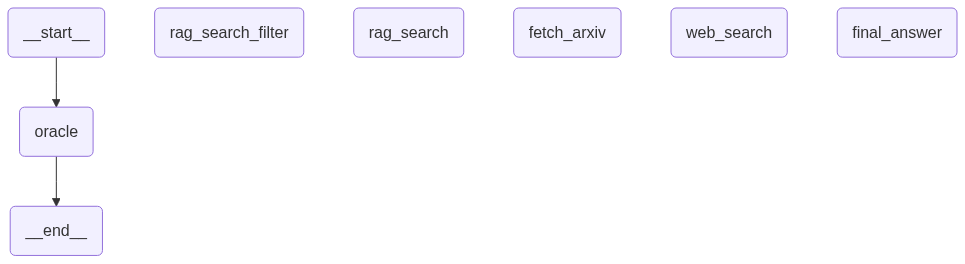

In [77]:
from IPython.display import Image,display

display(Image(runnable.get_graph().draw_mermaid_png()))

In [65]:
output=runnable.invoke({
    'input':'Tell me something intresting Dynamic Backtracking AI and LLMs',
    'chat_history':[],  
})

run_oracle
intermediate_steps: []
rag_search.invoke(input={'query': 'Dynamic Backtracking AI'})
run_oracle
intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'Dynamic Backtracking AI'}, log='TBD'), AgentAction(tool='rag_search', tool_input={'query': 'Dynamic Backtracking AI'}, log="Title: Dynamic Backtracking\nChunk: Journal of Arti/\x0ccial In telligence Researc h /1 /(/1/9/9/3/) /2/5/-/4/6 Submitted /7///9/3/; published /8///9/3\nDynamic Bac ktrac king\nMatthew L/. Ginsb erg ginsber g/@cs/.uoregon/.edu\nCIRL/, University of Or e gon/,\nEugene/, OR /9/7/4/0/3/-/1/2/6/9 USA\nAbstract\nBecause of their o ccasional need to return to shallo w p oin ts in a searc h tree/, existing\nbac ktrac king metho ds can sometimes erase meaningful progress to w ard solving a searc h\nArXiv ID: 9308101v1\n\n---\nTitle: Dynamic Backtracking\nChunk: D ynamic Ba cktra cking\nPro of/. That few er no des are examined is clear/; for completeness/, it follo ws from Lemma\n/3/./2 that the

### Generating reports

In [78]:
output['intermediate_steps'][-1].tool_input

{'introduction': 'Dynamic Backtracking and Large Language Models (LLMs) are two fascinating areas in the field of artificial intelligence, each contributing uniquely to problem-solving and language processing. Dynamic Backtracking offers a novel approach to constraint satisfaction problems, while LLMs represent a significant advancement in natural language understanding and generation.',
 'research_steps': "1. Conducted a RAG search for 'Dynamic Backtracking AI' to gather detailed information from academic sources.\n2. Performed a RAG search for 'LLMs (Large Language Models)' to understand their structure and applications.\n3. Used a web search to find additional insights and practical applications of Dynamic Backtracking and LLMs.\n4. Attempted to fetch the abstract of a relevant ArXiv paper on Dynamic Backtracking for more in-depth information.",
 'main_body': 'Dynamic Backtracking is a sophisticated method used in artificial intelligence to solve constraint satisfaction problems mor

### Building formatted final report

In [79]:
def build_report(output: dict) -> str:
    '''Builds a formatted report based on the oracle's output.

    Args:
        output (dict): A dictionary containing the various sections of the report (graph's output).

    Returns:
        str: A formatted string containing the full research report.
    '''
    research_steps = output['research_steps']
    if isinstance(research_steps, list):
        research_steps = '\n'.join([f'- {r}' for r in research_steps])
    
    sources = output['sources']
    if isinstance(sources, list):
        sources = '\n'.join([f'- {s}' for s in sources])
    
    return f"""
        INTRODUCTION
        ------------
        {output['introduction']}
        
        RESEARCH STEPS
        --------------
        {research_steps}
        
        REPORT
        ------
        {output['main_body']}
        
        CONCLUSION
        ----------
        {output['conclusion']}
        
        SOURCES
        -------
        {sources}
    """

In [80]:
report = build_report(
    output=output['intermediate_steps'][-1].tool_input
)

print(report)


        INTRODUCTION
        ------------
        Dynamic Backtracking and Large Language Models (LLMs) are two fascinating areas in the field of artificial intelligence, each contributing uniquely to problem-solving and language processing. Dynamic Backtracking offers a novel approach to constraint satisfaction problems, while LLMs represent a significant advancement in natural language understanding and generation.

        RESEARCH STEPS
        --------------
        1. Conducted a RAG search for 'Dynamic Backtracking AI' to gather detailed information from academic sources.
2. Performed a RAG search for 'LLMs (Large Language Models)' to understand their structure and applications.
3. Used a web search to find additional insights and practical applications of Dynamic Backtracking and LLMs.
4. Attempted to fetch the abstract of a relevant ArXiv paper on Dynamic Backtracking for more in-depth information.

        REPORT
        ------
        Dynamic Backtracking is a sophisticated

In [82]:
output=runnable.invoke({
    'input':'tell me about fifa world cup 26',
    'chat_history':[]
})

run_oracle
intermediate_steps: []
web_search.invoke(input={'query': 'FIFA World Cup 2026 overview'})
run_oracle
intermediate_steps: [AgentAction(tool='web_search', tool_input={'query': 'FIFA World Cup 2026 overview'}, log='TBD'), AgentAction(tool='web_search', tool_input={'query': 'FIFA World Cup 2026 overview'}, log="2026 FIFA World Cup\nThe tournament will take place from June 11 to July 19, 2026. It will be jointly hosted by 16 cities in three North American countries.\nhttps://en.wikipedia.org/wiki/2026_FIFA_World_Cup\n---\nFIFA World Cup 2026™ | Host Cities, Dates, Teams & more\nThe 2026 edition of the World Cup will be the first with 48 teams · Hosting of the tournament will be shared between Canada, Mexico and the USA.\nhttps://www.fifa.com/en/tournaments/mens/worldcup/canadamexicousa2026/articles/fifa-world-cup-2026-hosts-cities-dates-usa-mexico-canada\n---\nFIFA World Cup 26™\nThe FIFA World Cup 26™ will be the 23rd edition of the tournament but the first to feature 48 teams a

In [83]:
report = build_report(
    output=output['intermediate_steps'][-1].tool_input
)

print(report)


        INTRODUCTION
        ------------
        The FIFA World Cup 2026 is set to be a landmark event in the history of international football, marking the first time the tournament will be hosted by three countries and feature an expanded roster of teams.

        RESEARCH STEPS
        --------------
        1. Conducted a web search to gather general information about the FIFA World Cup 2026.
2. Utilized a specialized AI search to find detailed insights about the event.
3. Compiled information from various sources to provide a comprehensive overview.

        REPORT
        ------
        The FIFA World Cup 2026 will be the 23rd edition of the tournament and is scheduled to take place from June 11 to July 19, 2026. This edition is particularly notable as it will be the first to feature 48 teams, expanding from the traditional 32-team format. The tournament will be jointly hosted by three North American countries: Canada, Mexico, and the United States. This marks the first time th

In [84]:
out=runnable.invoke({
    'input': 'Create a summary about this AxXiv paper with the ID 2409.17990',
    'chat_history': []
})

run_oracle
intermediate_steps: []
fetch_arxiv.invoke(input={'arxiv_id': '2409.17990'})
run_oracle
intermediate_steps: [AgentAction(tool='fetch_arxiv', tool_input={'arxiv_id': '2409.17990'}, log='TBD'), AgentAction(tool='fetch_arxiv', tool_input={'arxiv_id': '2409.17990'}, log='This paper proposes temporally aligned Large Language Models (LLMs) as a tool for longitudinal analysis of social media data. We fine-tune Temporal Adapters for Llama 3 8B on full timelines from a panel of British Twitter users, and extract longitudinal aggregates of emotions and attitudes with established questionnaires. We focus our analysis on the beginning of the COVID-19 pandemic that had a strong impact on public opinion and collective emotions. We validate our estimates against representative British survey data and find strong positive, significant correlations for several collective emotions. The obtained estimates are robust across multiple training seeds and prompt formulations, and in line with collec

In [86]:
report = build_report(
    output=out['intermediate_steps'][-1].tool_input
)

print(report)


        INTRODUCTION
        ------------
        The ArXiv paper with ID 2409.17990 explores the innovative use of temporally aligned Large Language Models (LLMs) for the longitudinal analysis of social media data. This research is particularly focused on understanding public opinion and collective emotions during significant events, such as the COVID-19 pandemic.

        RESEARCH STEPS
        --------------
        1. Retrieved the abstract of the paper using the ArXiv ID.
2. Attempted to gather additional context using a specialized search filter on ArXiv.
3. Conducted a general search for related topics using a specialist AI information tool.

        REPORT
        ------
        The paper introduces a novel approach by fine-tuning Temporal Adapters for Llama 3 8B on complete timelines from a panel of British Twitter users. This method allows for the extraction of longitudinal aggregates of emotions and attitudes using established questionnaires. The research specifically exami